# 🌙**Dreamscapes**
## Trasformare immagini reali in visioni oniriche con Neural Style Transfer


## 🌙 Contesto del progetto

Il sogno è uno spazio intermedio tra realtà e immaginazione, in cui le immagini
perdono rigidità e assumono nuove forme, colori e significati.

In questo progetto utilizzo tecniche di **Computer Vision** per esplorare
questa dimensione visiva, trasformando un’immagine reale in una rappresentazione
onirica attraverso il **Neural Style Transfer**.

L’obiettivo non è ottenere un risultato puramente artistico,
ma osservare come una rete neurale possa reinterpretare la realtà
combinando struttura e stile.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 🎭 Neural Style Transfer

Il Neural Style Transfer  permette di
combinare due immagini diverse:

- un’immagine di **contenuto**, che fornisce la struttura principale
- un’immagine di **stile**, che fornisce colori, texture e pattern

Il risultato è un’immagine che mantiene la forma del contenuto,
ma assume l’aspetto visivo dello stile.

In questo caso, il contenuto rappresenta la **realtà cosciente**,
mentre lo stile rappresenta il **mondo del sogno**.


In [ ]:
imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_path):
    image = Image.open(image_path).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
from google.colab import files

uploaded = files.upload()
print("File caricati:", list(uploaded.keys()))

Saving PSYCHEDELIC_photography_de_lucborell_(1410978189).jpg to PSYCHEDELIC_photography_de_lucborell_(1410978189).jpg
Saving jeremy-bishop-EwKXn5CapA4-unsplash.jpg to jeremy-bishop-EwKXn5CapA4-unsplash.jpg
File caricati: ['PSYCHEDELIC_photography_de_lucborell_(1410978189).jpg', 'jeremy-bishop-EwKXn5CapA4-unsplash.jpg']


## 🖼️ Scelta delle immagini

Per ottenere un risultato equilibrato e leggibile, ho selezionato due immagini: da Unsplash(contenuto)e da Wikimedia(style).
La struttura è:
- **Immagine di contenuto**: soggetto chiaro e riconoscibile, con una struttura forte
- **Immagine di stile**: composizione astratta e ricca di colore, senza forme figurative

Questa scelta permette allo stile di agire come atmosfera,
senza compromettere la leggibilità della scena originale.

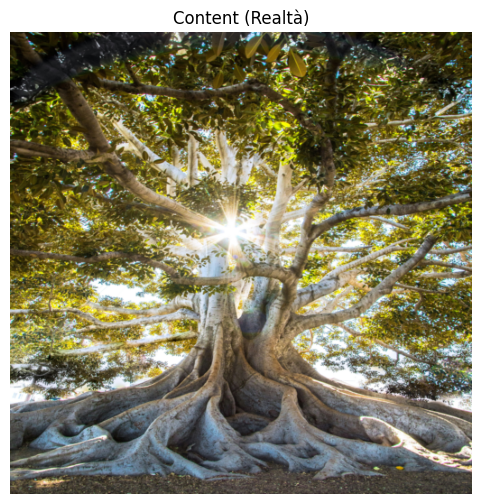

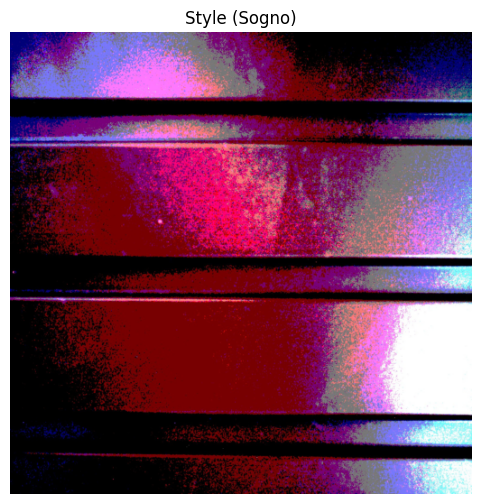

In [ ]:
content_path = "content.jpg"
style_path = "style.jpg"

content_img = image_loader(content_path)
style_img = image_loader(style_path)

imshow(content_img, "Content (Realtà)")
imshow(style_img, "Style (Sogno)")

## 🧠 Caricamento del Modello
 ho utilizzato una rete **VGG19 pre-addestrata**,
originariamente progettata per la classificazione di immagini.

Le feature estratte dai primi layer catturano informazioni di basso livello
(colore, texture), mentre i layer più profondi rappresentano strutture
più astratte e semantiche.

Questa caratteristica rende VGG particolarmente adatta
alla separazione tra contenuto e stile.


In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 74.6MB/s]


In [ ]:
#Loss Function=per controllare quanto l'immagine generata si discosta dall'immagine reale,ho creato una Content Loss e una Style Loss

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

## 🧩 Scelta dei layer e dell'intesità stilistica

Per ottenere un risultato **morbido,ma intenso** ci sono:

-  fino a 4 layer per lo style
- un layer intermedio per il **contenuto**, responsabile della struttura globale

Questa configurazione permette allo stile di emergere in modo più evidente,
senza compromettere la leggibilità della struttura originale.
L’obiettivo non è una trasformazione estrema,
ma un equilibrio tra realtà e sogno.


In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3','conv_4']  # per rendere un pò più visibile i colori delllo style

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, content_img, style_img):
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # taglia il modello dopo l'ultima loss
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], (ContentLoss, StyleLoss)):
            model = model[:j+1]
            break

    return model, style_losses,content_losses

In [ ]:
#Processo di ottimizzazione:attraverso l'iterazione l'immagine iniziale viene aggiornata per minimizzare una funzione di perdita combinata
input_img = content_img.clone()

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, content_img, style_img
)

optimizer = optim.LBFGS([input_img.requires_grad_()])

content_weight = 1e5
style_weight = 5e6  # morbido

print("✨ Ottimizzazione in corso...")

run = [0]
while run[0] <= 300:
    def closure():
        optimizer.zero_grad()
        model(input_img)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)

        loss = style_weight * style_score + content_weight * content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
           print(f"Step {run[0]} | Style: {style_score.item():.4f} | Content: {content_score.item():.4f}")

        return loss

    optimizer.step(closure)

✨ Ottimizzazione in corso...
Step 50 | Style: 0.0147 | Content: 0.0857
Step 100 | Style: 0.0143 | Content: 0.0888
Step 150 | Style: 0.0141 | Content: 0.0899
Step 200 | Style: 0.0140 | Content: 0.0904
Step 250 | Style: 0.0140 | Content: 0.0907
Step 300 | Style: 0.0139 | Content: 0.0908


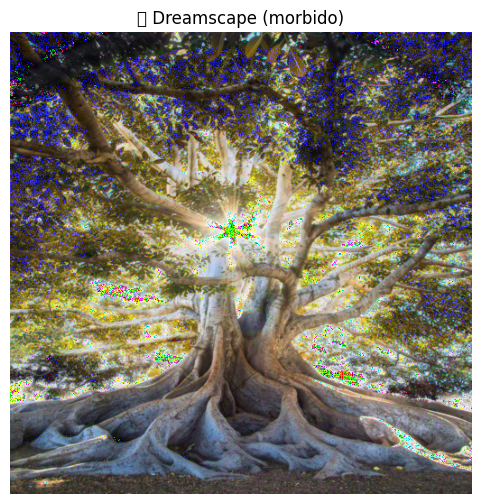

In [ ]:
imshow(input_img, "🌙 Dreamscape (morbido)")

## 🌌 Interpretazione del risultato finale

L’immagine risultante mantiene una struttura riconoscibile,
ma viene attraversata da colori e texture che ne alterano la percezione.

Il risultato può essere letto come una visione onirica:
la realtà è ancora presente, ma filtrata da una dimensione emotiva e astratta.

In questo senso, il Neural Style Transfer non agisce come semplice
applicazione di uno stile artistico,
ma come strumento di reinterpretazione visiva.
